# Workflow Debugging

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-04-17 12:17:28.396562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-17 12:17:28.396671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-17 12:17:28.494751: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 0s 11ms/step - loss: 3.8123 - accuracy: 0.4196
Epoch 2/100


2022-04-17 12:17:28.650159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 6ms/step - loss: 1.6389 - accuracy: 0.5175
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 1.6220 - accuracy: 0.5909
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 1.6897 - accuracy: 0.5944
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 1.8830 - accuracy: 0.5839
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 1.2448 - accuracy: 0.6049
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 1.0655 - accuracy: 0.6154
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 1.1020 - accuracy: 0.6469
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 1.0064 - accuracy: 0.6923
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.7519 - accuracy: 0.7343
Epoch 11/100
9/9 [==============================] - 0s 7ms/step - loss: 0.7296 - accuracy: 0.7273
Epoch 12/100
9/9 [======================

9/9 [==============================] - 0s 7ms/step - loss: 0.3819 - accuracy: 0.8497
Epoch 86/100
9/9 [==============================] - 0s 7ms/step - loss: 0.4745 - accuracy: 0.8531
Epoch 87/100
9/9 [==============================] - 0s 7ms/step - loss: 0.4316 - accuracy: 0.8392
Epoch 88/100
9/9 [==============================] - 0s 7ms/step - loss: 0.2737 - accuracy: 0.8811
Epoch 89/100
9/9 [==============================] - 0s 7ms/step - loss: 0.2229 - accuracy: 0.9021
Epoch 90/100
9/9 [==============================] - 0s 7ms/step - loss: 0.2791 - accuracy: 0.8846
Epoch 91/100
9/9 [==============================] - 0s 7ms/step - loss: 0.2939 - accuracy: 0.8566
Epoch 92/100
9/9 [==============================] - 0s 7ms/step - loss: 0.2730 - accuracy: 0.8531
Epoch 93/100
9/9 [==============================] - 0s 7ms/step - loss: 0.3143 - accuracy: 0.8601
Epoch 94/100
9/9 [==============================] - 0s 7ms/step - loss: 0.3431 - accuracy: 0.8531
Epoch 95/100
9/9 [===============

2022-04-17 12:17:35.192004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 12:17:35.381310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test data: 0.8211382627487183% 
 Error on test data: 0.17886173725128174
len(y_predicted) 123
graphstate_11  predicted:  3  should be:  2  diff:  208.89337300517062
qftentangled_21  predicted:  0  should be:  1  diff:  72.21239965180348
ghz_129  predicted:  5  should be:  0  diff:  0
su2random_21  predicted:  0  should be:  3  diff:  307.0730468753527
wstate_101  predicted:  0  should be:  5  diff:  189.40758293838826
wstate_11  predicted:  5  should be:  2  diff:  215.43739571694553
ghz_11  predicted:  5  should be:  2  diff:  55.554484311974086
qft_15  predicted:  0  should be:  1  diff:  21.208530805687587
su2random_11  predicted:  0  should be:  2  diff:  1463.482242658816
portfolioqaoa_11  predicted:  0  should be:  2  diff:  1711.889430702969
qftentangled_15  predicted:  0  should be:  3  diff:  21.851556135326973
wstate_103  predicted:  0  should be:  5  diff:  169.48670084147398
graphstate_67  predicted:  0  should be:  3  diff:  248.94506048472817
dj_47  predicted:

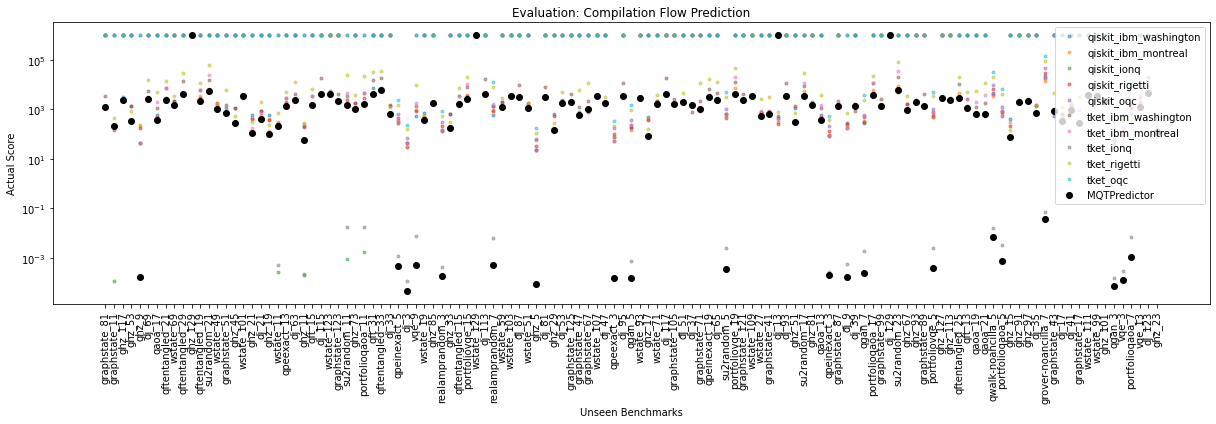

In [1]:
from evaluator.eval import extract_training_data_from_json, train_simple_ml_model
import numpy as np
training_data, names_list, scores_list = extract_training_data_from_json("big_1.json")
#print(names_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
X = X[:, [ 3,  5, 12, 14, 16, 17, 19, 20, 23, 25, 27, 30 ,37 ,38, 39, 40]]
X.shape
train_simple_ml_model(X,y, True, names_list, scores_list)

In [8]:
from sklearn.model_selection import train_test_split
from evaluator.src import utils
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")


features = np.sort(np.array(res))
features = features[[3,  5, 12, 14, 16, 17, 19, 20, 23, 25, 27, 30 ,37 ,38, 39, 40]]
print(features)


['ccx' 'cp' 'cu1' 'cx' 'cz' 'h' 'num_qubits' 'p' 'rx' 'ry' 'rzz' 'swap'
 'u1' 'u2' 'u3' 'x']


1 0.8148148148148148
2 0.8592592592592593
3 0.837037037037037
4 0.8666666666666667
5 0.8518518518518519
6 0.8740740740740741
7 0.837037037037037
8 0.8666666666666667
9 0.8888888888888888


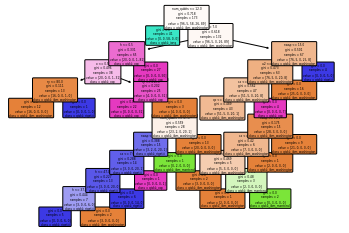

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

#Create a Gaussian Classifier
for i in range(1,10,1):
    clf=RandomForestClassifier(n_estimators=i)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    print(i, np.mean(y_pred == y_test))
    plot_tree(clf.estimators_[0], 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);

In [10]:
from sklearn.svm import SVC
#Create a Gaussian Classifier

clf=SVC(kernel="linear")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.837037037037037


In [11]:
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5185185185185185


In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier


clf = AdaBoostClassifier(n_estimators=10)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5407407407407407


0.8814814814814815


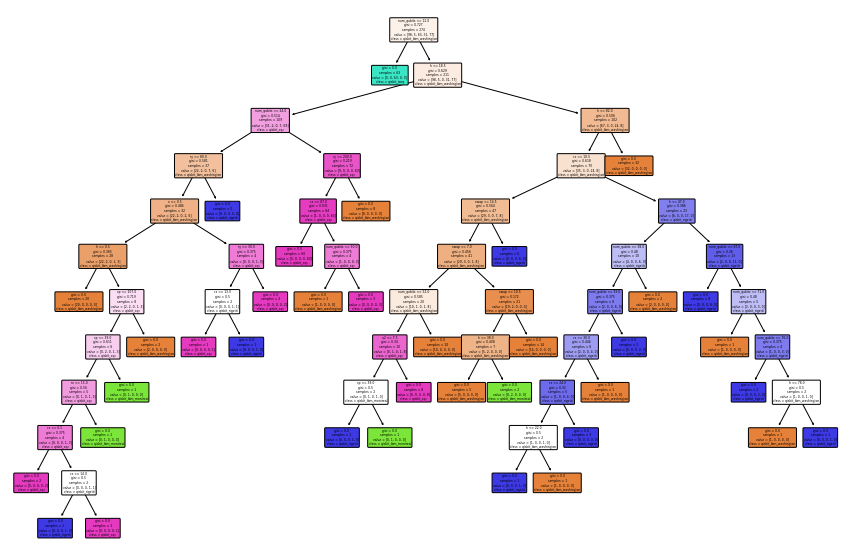

In [14]:

import matplotlib.pyplot as plt
from evaluator.src import utils
from sklearn.tree import plot_tree
from sklearn import tree


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)

fig = plt.figure(figsize=(15, 10))

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))
plot_tree(clf, 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);
plt.savefig("random_forest.png", dpi=600)

# Debugging

In [1]:
from evaluator import eval
from evaluator.src import utils, pytket_plugin, qiskit_plugin
import pytest
from pytket.extensions.qiskit import qiskit_to_tk
from mqt.bench import get_one_benchmark
from pytket import circuit, OpType

In [6]:
benchmarks = [
    "dj",
    "grover-noancilla",
    "grover-v-chain",
    "ghz",
    "graphstate",
    "qft",
    "qftentangled",
    "qpeexact",
    "qpeinexact",
    "qwalk-noancilla",
    "qwalk-v-chain",
    "realamprandom",
    "su2random",
    "twolocalrandom",
    "vqe",
    "wstate",
    "qaoa",
    "portfoliovqe",
    "portfolioqaoa",
    "qgan",
]
res = []
timeout=10
for benchmark in benchmarks:
    for num_qubits in range(4, 5, 1):
        print(benchmark, num_qubits)
        qc = eval.timeout_watcher(
            get_one_benchmark,
            [benchmark, 1, num_qubits],
            timeout,
        )
        if not qc:
            break
        print("1")
        actual_num_qubits = qc.num_qubits
        qiskit_gates = eval.timeout_watcher(eval.get_qiskit_gates, [qc], timeout)
        if not qiskit_gates:
            break
        try:
            qc_tket = qiskit_to_tk(qc)
            ops_list = qc.count_ops()
            print("2")
            feature_vector = eval.dict_to_featurevector(ops_list, actual_num_qubits)
            tket_gates = eval.timeout_watcher(eval.get_tket_gates, [qc_tket], timeout)
            
            print("3")
            if not tket_gates:
                break
            benchmark_name = benchmark + "_" + str(num_qubits)
            res.append(
                (
                    benchmark,
                    feature_vector,
                    qiskit_gates + tket_gates,
                    benchmark_name,
                )
            )
        except Exception as e:
            print("fail: ", e)


dj 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
grover-noancilla 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
grover-v-chain 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
ghz 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
graphstate 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
qft 4
1


KeyboardInterrupt: 